# Markov Chain Monte Carlo (MCMC)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from scipy import stats

[ 0.35013056  0.28873508  0.36113436]


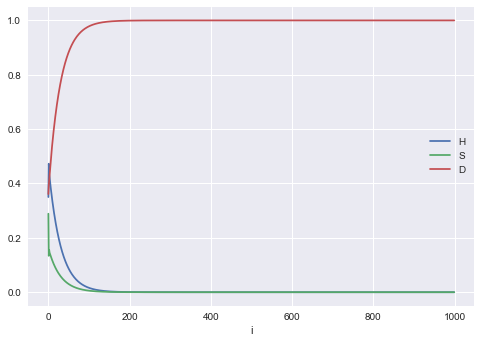

In [5]:
# transition matrix
T = np.array([[0.69,0.3,0.01],[0.8,0.1,0.1],[0.0,0.0,1.0]])

# random initial state
p = np.random.uniform(low=0,high=1,size=3)
# normalize
p = p/np.sum(p)
print p

q = np.zeros((1000,3))
for i in np.arange(0,1000):
    q[i,:] = np.dot(p,np.linalg.matrix_power(T,i))

plt.plot(q)
plt.xlabel('i')
plt.legend(('H','S','D'))
plt.show()


## Markov chain sampling
sample from $p(x) = 6x(1-x)$

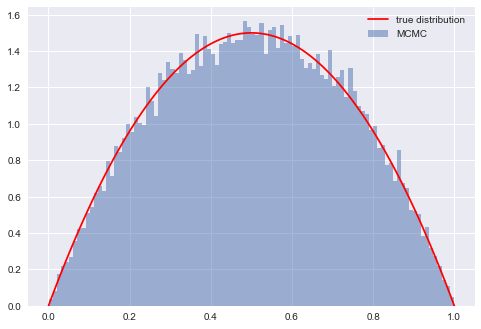

In [13]:
# Metropolis-Hasting algorithm
def p(x):
    return 6*x*(1-x)

# sample size
NUM = 100000

# proposal distribution
sig = 0.5

# initial state
x0 = np.random.uniform()
x_prev = x0

x = []
for i in xrange(NUM):
    x_star = np.random.normal(x_prev,sig)
    P_star = p(x_star)
    P_prev = p(x_prev)
    A = P_star/P_prev
    
    # generate a random number between 0 and 1
    U = np.random.uniform()
    if (A>U):
        # accept
        x_prev = x_star
    
    x.append(x_prev)

plt.hist(x,bins=100,normed=True,label='MCMC',alpha=0.5)
xx = np.linspace(0,1,100)
plt.plot(xx,p(xx),color='red',label='true distribution')
plt.legend()
plt.show()    

## Bayesian statistics
### Flipping coin example

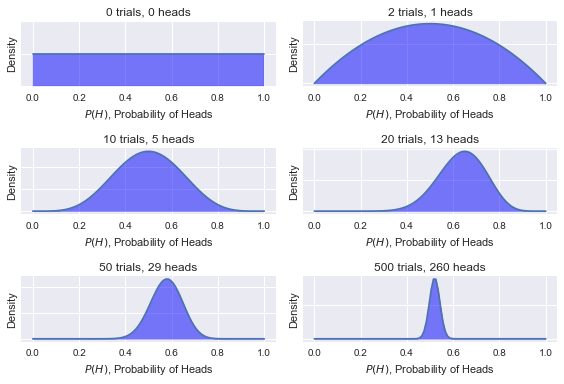

In [15]:
# Create a list of the number of coin tosses ("Bernoulli trials")
number_of_trials = [0, 2, 10, 20, 50, 500]

# Conduct 500 coin tosses and output into a list of 0s and 1s
# where 0 represents a tail and 1 represents a head
data = stats.bernoulli.rvs(0.5, size=number_of_trials[-1])

# Discretise the x-axis into 100 separate plotting points
x = np.linspace(0, 1, 100)

# Loops over the number_of_trials list to continually add
# more coin toss data. For each new set of data, we update
# our (current) prior belief to be a new posterior. This is
# carried out using what is known as the Beta-Binomial model.
# For the time being, we won't worry about this too much. It 
# will be the subject of a later article!
for i, N in enumerate(number_of_trials):
    # Accumulate the total number of heads for this 
    # particular Bayesian update
    heads = data[:N].sum()

    # Create an axes subplot for each update 
    ax = plt.subplot(len(number_of_trials) / 2, 2, i + 1)
    ax.set_title("%s trials, %s heads" % (N, heads))

    # Add labels to both axes and hide labels on y-axis
    plt.xlabel("$P(H)$, Probability of Heads")
    plt.ylabel("Density")
    if i == 0:
        plt.ylim([0.0, 2.0])
    plt.setp(ax.get_yticklabels(), visible=False)

    # Create and plot a  Beta distribution to represent the 
    # posterior belief in fairness of the coin.
    y = stats.beta.pdf(x, 1 + heads, 1 + N - heads)
    plt.plot(x, y, label="observe %d tosses,\n %d heads" % (N, heads))
    plt.fill_between(x, 0, y, color="blue", alpha=0.5)

# Expand plot to cover full width/height and show it
plt.tight_layout()
plt.show()


Example: In this experiment 5 animals were tested for various doses and the number of deaths were recorded. The death rate is usually modeled as $logit^{-1}$  with two parameters (see below). The goal is to estimate those parameters and be able to infer death rates as a function of dose.

| Dose $$\log(x_i)$$ | Number of animals $$n_i$$  | Number of deaths $$y_i$$|
|:------------:|:------------:|:------------:|
| -0.86      |     5       |     0        |
| -0.30      |     5       |     1        |
| -0.05      |     5       |     3        |
|  0.73      |     5       |     5        |

The likelihood since is a success/fail experiment is expressed as a Binomial:

$$ P(D_i|\theta_i) = p(y_i, n_i| \theta_i) = {\rm Bionomial}( y_i, n_i \vert \theta_i)  \,\,\,\,    \rm{for}\,\, i=1, \ldots, 4$$

where $\theta$ is the rate of deaths which is modeled as a $\rm{logit}^{-1}$:  

$$ \theta_i = {\rm logit}^{-1}(\alpha+\beta x_i) \,\,\,\, \rm{for} \,\, i=1, \ldots, 4$$

We use flat priors for $\alpha,\beta$: 

$$ p(\alpha, \beta) \propto 1 $$

Posterior: 

$$ p(\alpha, \beta \vert y) \propto p(\alpha, \beta) \prod_{i=1}^{k} p(y_i \vert \alpha, \beta, n_i, x_i) $$
$$ = 1 \prod_{i=1}^{k} [{\rm logit}^{-1}(\alpha+\beta x_i)]^{y_i} [ 1-{\rm logit}^{-1}(\alpha+\beta x_i)]^{n_i-y_i} $$



In [27]:
# metropolis sampling function
def metropolis(n_iterations, initial_values, prop_sd = [1,1]):
    n_params = len(initial_values)
    
    trace = np.empty((n_iterations+1,n_params))
    
    trace[0] = initial_values
    
    # compute the joint posterior for inital values
    current_prob = posterior(*trace[0])
    
    accepted = [0]*n_params
    
    for i in range(n_iterations):
        current_params = trace[i]
        p = trace[i].copy()
        
        for j in range(n_params):
            theta = np.random.normal(current_params[j],prop_sd[j])
            
            p[j] = theta
            
            # compute posterior with proposed value
            proposed_prob = posterior(*p)
            
            alpha = proposed_prob/current_prob
            
            u = np.random.rand()
            
            if (u < alpha):
                # accept
                trace[i+1,j] = theta
                current_prob = proposed_prob
                accepted[j]+=1
            else:
                # reject
                trace[i+1,j] = trace[i,j]
            
            # update p so we can search the next dimension according to the current result
            p[j] = trace[i+1,j]
            
    return trace,accepted

In [22]:
n = 5
X = np.array([-0.86,-0.3,-0.05,0.73])
Y = np.array([0,1,3,5])

def logitInv(x):
    return np.exp(x)/(1.0+np.exp(x))

# posterior
def posterior(alpha,beta,y=Y,x=X):
    p = np.product((logitInv(alpha+beta*x)**y)*(1.0-logitInv(alpha+beta*x))**(n-y))
    return p

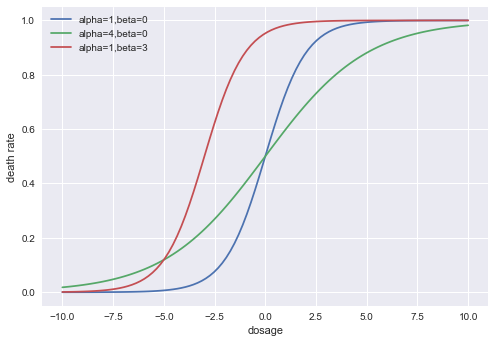

In [23]:
xx = np.linspace(-10,10,100)
plt.plot(xx,logitInv(xx),label='alpha=1,beta=0')
plt.plot(xx,logitInv(0.4*xx),label='alpha=4,beta=0')
plt.plot(xx,logitInv(xx+3),label='alpha=1,beta=3')
plt.xlabel('dosage')
plt.ylabel('death rate')
plt.legend()
plt.show()

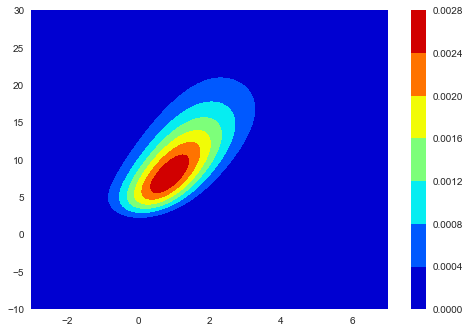

In [24]:
x1 = np.linspace(-3,7,100)
x2 = np.linspace(-10,30,100)
pos = np.zeros((100,100))
k = 0
for xx1 in x1:
    j = 0
    for xx2 in x2:
        pos[k,j] = posterior(xx1,xx2)
        j +=1
    k +=1
plt.contourf(x1,x2,pos.T,cmap=plt.cm.jet)
plt.colorbar()
plt.show()

In [28]:
n_iter = 10000
acc_ratios = []
alpha0 = np.random.rand(1)*10-3
beta0 = np.random.rand(1)*40-10
trace,acc= metropolis(n_iter,(alpha0,beta0),[3.0,12.0])
acc_ratios.append(acc/np.double(n_iter))



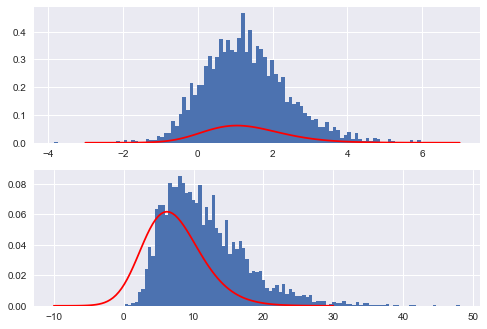

In [31]:
alpha = trace[:,0]
beta = trace[:,1]

plt.subplot(2,1,1)
plt.hist(alpha,bins=100,normed=True)
xx = np.linspace(-3,7,100)
pos_alpha = np.sum(pos,axis=1)
plt.plot(xx,pos_alpha,color='red')

plt.subplot(2,1,2)
plt.hist(beta,bins=100,normed=True)
yy = np.linspace(-10,30,100)
pos_beta = np.sum(pos,axis=1)
plt.plot(yy,pos_beta,color='red')

plt.show()

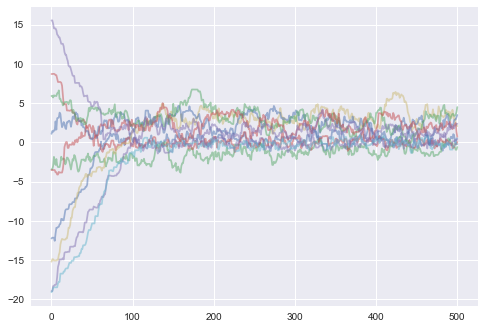

In [36]:
n_iter = 500
for i in range(10):
    start_alpha = np.random.rand(1)*40-20
    start_beta = np.random.rand(1)*40-10
    trace,acc = metropolis(n_iter,(start_alpha,start_beta),[0.5,0.05])
    plt.plot(trace[:,0],alpha=0.5)
plt.show()